In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import time
import os
import seaborn as sns
from tqdm import tqdm
import scipy.stats as ss
import keras
from keras import metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, CuDNNLSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from DataPreparation.dataset_preparation import get_LANL_data
from Utilities.evaluation_utils import save_submission, LossPlot

import tensorflow as tf
import warnings
tf.logging.set_verbosity(tf.logging.ERROR)
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<b>Baseline Model</b>

Slicing the training set (3305 samples, WITH failures).

Random splitting the validation set (1000 samples, no failures).

# 1. Load Dataset

In [2]:
# data_dir = '../Data/LANL_Earthquake_prediction/'
# method = 'slicing' # 'slicing', 'random'
# n = 5000
# seq_len = 150000
# X_train, y_train, X_val, y_val, X_test_dict, X_train_moments = get_LANL_data(data_dir, method, n)
# print('-------------')
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
# print('Number of test files: %d' % len(X_test_dict))

In [3]:
# data_dir = '../Data/LANL_Earthquake_prediction/'
# method = 'random' # 'slicing', 'random'
# n = 4000
# seq_len = 150000
# X_train, y_train, X_val, y_val, X_test_dict, X_train_moment = get_LANL_data(data_dir, method, n)
# print('-------------')
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
# print('Number of test files: %d' % len(X_test_dict))

In [4]:
data_dir = '../Data/LANL_Earthquake_prediction/'
method = 'raw' # 'slicing', 'random'
n = 5000
seq_len = 150000
X_train, y_train, X_val, y_val, X_test_dict, X_train_moments = get_LANL_data(data_dir, method, n)
print('-------------')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Number of test files: %d' % len(X_test_dict))

Reading data...
Splitting & Sampling...
Standardizing...
[DONE]
-------------
(495800225,)
(495800225,)
(133345255,)
(133345255,)
Number of test files: 2624


# 2. Build Model

In [5]:
from keras.utils import Sequence
from DataPreparation.dataset_preparation import uniform_from_slices, sample_sequences

seq_len = 150000
earthquake_ind = [0, 5656574, 50085878, 104677356,
                  138772453, 187641820, 218652630, 245829585,
                  307838917, 338276287, 375377848, 419368880,
                  461811623, 495800225, 528777115, 585568144,
                  621985673]
train_eq_ind = earthquake_ind[:-4]
train_slicing_ranges = [(train_eq_ind[i], (train_eq_ind[i+1]-seq_len)) for i in range(len(train_eq_ind)-1)]
train_sample_size = n # 3355

len_train_total = len(X_train) + len(X_val)
val_eq_ind = np.hstack([earthquake_ind[-4:], len_train_total])
val_eq_ind -= np.min(val_eq_ind)
val_slicing_ranges = [(val_eq_ind[i], (val_eq_ind[i+1]-seq_len)) for i in range(len(val_eq_ind)-1)]

class MY_Generator(Sequence):
    def __init__(self, inputs, labels, batch_size, num_samples, slicing_ranges):
        self.inputs, self.labels = inputs, labels
        self.batch_size, self.num_samples = batch_size, num_samples
        self.slicing_ranges = slicing_ranges

    def __len__(self):
        return int(float(self.num_samples) / float(self.batch_size))

    def __getitem__(self, idx):     
        sample_ind = uniform_from_slices(self.slicing_ranges, self.batch_size)
        batch_x, batch_y = sample_sequences(self.inputs, self.labels, sample_ind, seq_len)
        batch_x = batch_x[:, :, None]
        return batch_x, batch_y

In [6]:
num_features = 30

def subseq_feature_extractor(x):
    features = [np.mean(x, axis=1, keepdims=True), np.std(x, axis=1, keepdims=True),
                np.min(x, axis=1, keepdims=True), np.max(x, axis=1, keepdims=True)]
    return np.concatenate(features, axis=1)

def subseq_feature_extractor(x):
    features = [np.mean(x, axis=1, keepdims=True), np.std(x, axis=1, keepdims=True),
                np.min(x, axis=1, keepdims=True), np.max(x, axis=1, keepdims=True),
                np.mean(abs(x), axis=1, keepdims=True), np.median(x, axis=1, keepdims=True),
                np.min(abs(x), axis=1, keepdims=True), np.max(abs(x), axis=1, keepdims=True),
                ss.kurtosis(x, axis=1)[:, None], ss.skew(x, axis=1)[:, None]]
    return np.concatenate(features, axis=1)

def seq_feature_extractor(x):
    subsequences = x.reshape(100, -1)
    features = [subseq_feature_extractor(subsequences),
                subseq_feature_extractor(subsequences[:, -15:]),
                subseq_feature_extractor(subsequences[:, -150:])]
    return np.concatenate(features, axis=1)

class Feature_Extraction_Generator(Sequence):
    def __init__(self, inputs, labels, batch_size, num_samples, slicing_ranges):
        self.inputs, self.labels = inputs, labels
        self.batch_size, self.num_samples = batch_size, num_samples
        self.slicing_ranges = slicing_ranges

    def __len__(self):
        return int(float(self.num_samples) / float(self.batch_size))

    def __getitem__(self, idx):     
        sample_ind = uniform_from_slices(self.slicing_ranges, self.batch_size)
        batch_x, batch_y = sample_sequences(self.inputs, self.labels, sample_ind, seq_len)
        batch_features = []
        for i in range(len(batch_x)):
            batch_features.append(seq_feature_extractor(batch_x[i]))
        batch_x = np.asarray(batch_features)
        return batch_x, batch_y

In [19]:
model = Sequential()
model.add(CuDNNLSTM(1500, return_sequences=True, input_shape=(None, num_features)))
model.add(CuDNNLSTM(1500))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

In [20]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=15,
                              verbose=0,
                              mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5',
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=5,
                                   verbose=1,
                                   epsilon=1e-4,
                                   mode='min')

model.compile(loss='mean_absolute_error', optimizer= adam(lr=1e-4, decay=1e-4), metrics=['mean_absolute_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_8 (CuDNNLSTM)     (None, None, 1500)        9192000   
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 1500)              18012000  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               150100    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 27,354,201
Trainable params: 27,354,201
Non-trainable params: 0
_________________________________________________________________


# 3. Train Model

In [21]:
liveplot = LossPlot()

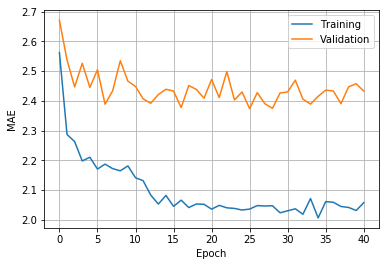

In [22]:
# # TRAIN WITH MAE
# model.fit(X_train,
#         y_train,
#         batch_size= 16,
#         epochs= 100,
#         validation_data= (X_val, y_val),
#         callbacks=[mcp_save, reduce_lr_loss, liveplot],
#         verbose=0
#          )

# Train RNN with Generator
batch_size = 16
num_train_samples = 10000
num_validation_samples = 5000
train_generator = Feature_Extraction_Generator(X_train, y_train, batch_size, num_train_samples, train_slicing_ranges)
val_generator = Feature_Extraction_Generator(X_val, y_val, batch_size, num_validation_samples, val_slicing_ranges)
model.fit_generator(train_generator,
                  steps_per_epoch=(num_train_samples // batch_size),
                  epochs=100,
                  verbose=0,
                  callbacks=[earlyStopping, mcp_save, reduce_lr_loss, liveplot],
                  validation_data=val_generator,
                  validation_steps=(num_validation_samples // batch_size))

# # Train with Generator
# batch_size = 16
# num_train_samples = 10000
# num_validation_samples = 5000
# train_generator = MY_Generator(X_train, y_train, batch_size, num_train_samples, train_slicing_ranges)
# val_generator = MY_Generator(X_val, y_val, batch_size, num_validation_samples, val_slicing_ranges)
# model.fit_generator(generator=train_generator,
#                     steps_per_epoch=(num_train_samples // batch_size),
#                     epochs=100,
#                     verbose=0,
#                     validation_data=val_generator,
#                     validation_steps=(num_validation_samples // batch_size),
#                     callbacks=[mcp_save, reduce_lr_loss, liveplot]
#                     )


# 4. Evaluate Model

In [11]:
# Load model
model = load_model('LSTM.mdl_wts.hdf5')
batch_size = 16
num_train_samples = 10000
num_validation_samples = 5000
train_generator = Feature_Extraction_Generator(X_train, y_train, batch_size, num_train_samples, train_slicing_ranges)
val_generator = Feature_Extraction_Generator(X_val, y_val, batch_size, num_validation_samples, val_slicing_ranges)

## A. MAE Scores

In [12]:
# train_mae = model.evaluate(X_train, y_train, verbose=0)
# val_mae = model.evaluate(X_val, y_val, verbose=0)

train_mae = model.evaluate_generator(train_generator, verbose=0)
val_mae = model.evaluate_generator(val_generator, verbose=0)

print('Train MAE: %.4f' % train_mae[0])
print('Validation MAE: %.4f' % val_mae[0])

Train MAE: 2.0035
Validation MAE: 2.3653


## B. Validation Predictions vs Targets

In [13]:
y_pred = []
y_val_ = []
X_val_ = []
for _ in range(100):
    X_val_temp, y_val_temp = val_generator.__getitem__(5)
    y_val_.append(y_val_temp)
    y_pred.append(np.squeeze(model.predict(X_val_temp)))
    X_val_.append(np.squeeze(X_val_temp))

y_val_ = np.hstack(y_val_)
y_pred = np.hstack(y_pred)

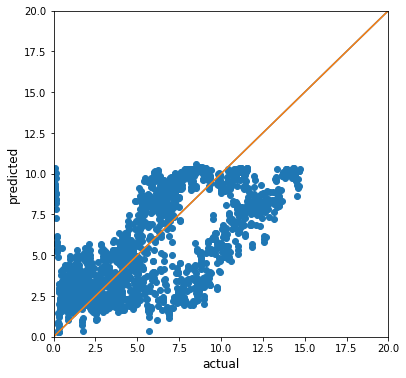

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val_, y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.savefig("plots/LSTM/prediction_vs_target/validation.jpg")
plt.show()

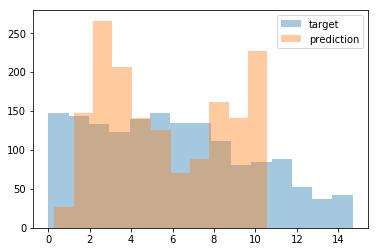

In [15]:
sns.distplot(y_val_, kde=False, label='target');
sns_plot = sns.distplot(y_pred, kde=False, label='prediction');
plt.legend();
sns_plot.get_figure().savefig("plots/LSTM/prediction_hist/validation.jpg")

## B. Training Predictions vs Targets

In [16]:
y_pred_train = []
y_train_ = []
X_train_ = []
for _ in range(100):
    X_train_temp, y_train_temp = train_generator.__getitem__(5)
    y_train_.append(y_train_temp)
    y_pred_train.append(np.squeeze(model.predict(X_train_temp)))
    X_train_.append(np.squeeze(X_train_temp))

y_train_ = np.hstack(y_train_)
y_pred_train = np.hstack(y_pred_train)

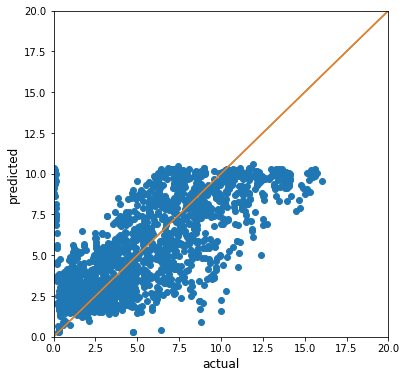

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train_, y_pred_train)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.savefig("plots/LSTM/prediction_vs_target/train.jpg")
plt.show()

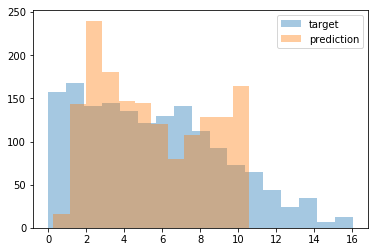

In [18]:
sns.distplot(y_train_, kde=False, label='target');
sns_plot = sns.distplot(y_pred_train, kde=False, label='prediction');
plt.legend();
sns_plot.get_figure().savefig("plots/LSTM/prediction_hist/train.jpg")

## C. Save Test Submission

In [31]:
X_test = []
segment_ids = []
for seg_id, X_test_i in X_test_dict.items():
    X_test.append(seq_feature_extractor(X_test_i))
    segment_ids.append(seg_id)

X_test = np.asarray(X_test)
y_test_pred = np.squeeze(model.predict(X_test)).tolist()

prediction_dict = {seg_id:pred for seg_id, pred in zip(segment_ids, y_test_pred)}
save_submission(prediction_dict, 'LSTM')